In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [2]:
# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [3]:
data = pd.read_csv('source/data.csv')

C:\Users\sd10725\AppData\Local\Temp\ipykernel_19816\2657006601.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('source/data.csv')


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469506 entries, 0 to 469505
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AccID                       469506 non-null  int64  
 1   day                         469506 non-null  int64  
 2   month                       469506 non-null  int64  
 3   year                        469506 non-null  int64  
 4   time                        469506 non-null  object 
 5   lum                         469506 non-null  int64  
 6   dep_code                    469506 non-null  float64
 7   com_code                    469506 non-null  object 
 8   location                    469506 non-null  int64  
 9   int                         469506 non-null  int64  
 10  atm_condition               469506 non-null  int64  
 11  collision_type              469506 non-null  int64  
 12  address                     469506 non-null  object 
 13  lat           

In [ ]:
data.head()

C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


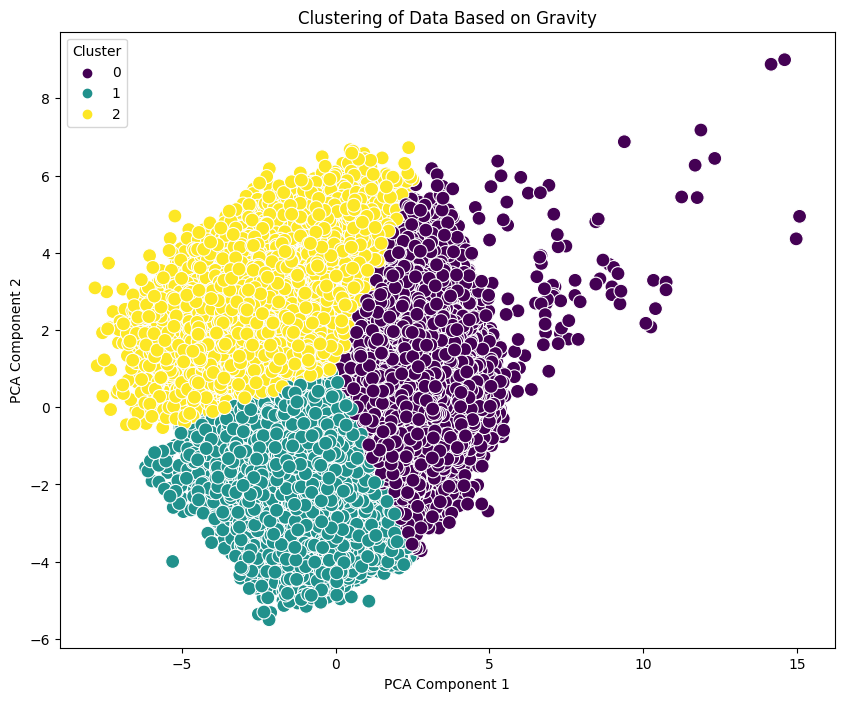

In [5]:
# Selecting numeric columns only and excluding the target 'gravity'
numeric_columns = data.select_dtypes(include=['int64', 'float64']).drop(columns=['gravity'])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)

# Apply PCA to reduce dimensionality for better clustering
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Choosing 3 clusters for simplicity
clusters = kmeans.fit_predict(pca_data)

# Add the cluster information to the original data
data['Cluster'] = clusters

# Plotting the clusters with respect to PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=data['Cluster'], palette='viridis', s=100)
plt.title('Clustering of Data Based on Gravity')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

Key Features Contributing to Each PCA Component: PCA Component 1:

Location (0.474): This has the highest positive loading on PCA Component 1, meaning the geographical location of the accident strongly contributes to the variance captured by this component. Route Category (0.377): This indicates the type of road involved in the accident is also a significant factor. Maximum Speed (-0.446): This negative loading suggests that higher speeds reduce the PCA Component 1 score, likely contributing to a different type of accident scenario compared to those associated with high-speed environments. Traffic Regime (-0.190): This suggests that traffic management measures play a role in this component, with different regimes potentially leading to different accident characteristics. PCA Component 2:

Seat (0.435) and User Category (0.439): These features have high positive loadings, indicating that the type of user and seating position in the vehicle contribute significantly to this component. These could relate to the severity or type of accidents. Collision Type (0.382): The way a collision occurs is a strong determinant in PCA Component 2, highlighting the nature of the accidents. Accident Situation (0.224): The circumstances under which the accident occurred also play a role here. Interpretation of Clusters Based on PCA Components:

Cluster 0: With higher values in PCA Component 1, accidents in this cluster might be more influenced by factors like the location and type of road, possibly representing more severe or complex traffic scenarios. The negative loading of maximum speed could indicate that these accidents occur at lower speeds but in more congested or urban environments.

Cluster 1: This cluster is separated primarily along PCA Component 1 as well, but with different values that could be linked to specific types of roads and locations. The mix of high and low loadings suggests that this cluster might involve accidents with mixed characteristics, including different traffic regimes and speeds.

Cluster 2: This cluster, influenced by PCA Component 2, might represent accidents where the type of vehicle, seating position, and collision type play a significant role. The importance of collision type and seating arrangement suggests that these accidents may be more severe, involving higher vehicle occupancy or specific impact points.

Summary: PCA Component 1 primarily captures the geographical and traffic-related aspects of accidents, such as location, road type, and traffic conditions. PCA Component 2 captures the characteristics related to the vehicle and collision specifics, like the seating position, user category, and type of collision.

Cluster 1 (Yellow) indicates the highest risk, as it not only has the highest average severity (gravity) but also includes characteristics that suggest more complex and potentially more dangerous accidents.

In [6]:
# Filter the data to include only rows from Cluster 0
cluster_0_data = data[data['Cluster'] == 0]

# Prepare the data for modeling
X_cluster_0 = cluster_0_data.drop(columns=['gravity', 'Cluster'])
y_cluster_0 = cluster_0_data['gravity']

# Convert or drop any non-numeric features for simplicity
X_cluster_0_cleaned = X_cluster_0.select_dtypes(exclude=['object'])

# Split the data into training and testing sets
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_cluster_0_cleaned, y_cluster_0, test_size=0.3, random_state=42)

# Train the Random Forest model
rf_model_0 = RandomForestClassifier(random_state=42)
rf_model_0.fit(X_train_0, y_train_0)

# Predict and evaluate the model
y_pred_0 = rf_model_0.predict(X_test_0)
accuracy_0 = accuracy_score(y_test_0, y_pred_0)

# Get feature importances for Cluster 0
feature_importances_0 = pd.DataFrame({
    'Feature': X_cluster_0_cleaned.columns,
    'Importance': rf_model_0.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Show the top features for Cluster 0
feature_importances_0.head(10), accuracy_0



(                     Feature  Importance
 10                       lat    0.067382
 11                      long    0.065315
 37                       age    0.056506
 34                birth_year    0.056148
 18  upstream_terminal_number    0.051627
 5                   dep_code    0.050954
 1                        day    0.050855
 25          vehicle_category    0.044002
 9             collision_type    0.040899
 2                      month    0.040323,
 0.6001607532437708)

In [7]:
# Filter the data to include only rows from Cluster 1
cluster_1_data = data[data['Cluster'] == 1]

# Prepare the data for modeling
X_cluster_1 = cluster_1_data.drop(columns=['gravity', 'Cluster'])
y_cluster_1 = cluster_1_data['gravity']

# Convert or drop any non-numeric features for simplicity
X_cluster_1_cleaned = X_cluster_1.select_dtypes(exclude=['object'])

# Split the data into training and testing sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_cluster_1_cleaned, y_cluster_1, test_size=0.3, random_state=42)

# Train the Random Forest model
rf_model_1 = RandomForestClassifier(random_state=42)
rf_model_1.fit(X_train_1, y_train_1)

# Predict and evaluate the model
y_pred_1 = rf_model_1.predict(X_test_1)
accuracy_1 = accuracy_score(y_test_1, y_pred_1)

# Get feature importances for Cluster 1
feature_importances_1 = pd.DataFrame({
    'Feature': X_cluster_1_cleaned.columns,
    'Importance': rf_model_1.feature_importances_
}).sort_values(by='Importance', ascending=False)


# Show the top features for Cluster 1
feature_importances_1.head(10), accuracy_1


(              Feature  Importance
 36  safety_equipment1    0.098722
 25   vehicle_category    0.096788
 10                lat    0.060257
 11               long    0.058186
 37                age    0.048280
 34         birth_year    0.047718
 1                 day    0.042394
 27    mobile_obstacle    0.038083
 5            dep_code    0.037645
 9      collision_type    0.036168,
 0.7398124676315861)

In [8]:
# Filter the data to include only rows from Cluster 2
cluster_2_data = data[data['Cluster'] == 2]

# Prepare the data for modeling
X_cluster_2 = cluster_2_data.drop(columns=['gravity', 'Cluster'])
y_cluster_2 = cluster_2_data['gravity']

# Convert or drop any non-numeric features for simplicity
X_cluster_2_cleaned = X_cluster_2.select_dtypes(exclude=['object'])

# Split the data into training and testing sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_cluster_2_cleaned, y_cluster_2, test_size=0.3, random_state=42)

# Train the Random Forest model
rf_model_2 = RandomForestClassifier(random_state=42)
rf_model_2.fit(X_train_2, y_train_2)

# Predict and evaluate the model
y_pred_2 = rf_model_2.predict(X_test_2)
accuracy_2 = accuracy_score(y_test_2, y_pred_2)

# Get feature importances for Cluster 2
feature_importances_2 = pd.DataFrame({
    'Feature': X_cluster_2_cleaned.columns,
    'Importance': rf_model_2.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Show the top features for Cluster 2
feature_importances_2.head(10), accuracy_2


(                     Feature  Importance
 10                       lat    0.074882
 11                      long    0.067855
 34                birth_year    0.058496
 37                       age    0.057401
 5                   dep_code    0.053440
 1                        day    0.048970
 0                      AccID    0.038349
 2                      month    0.038083
 31                      seat    0.036469
 18  upstream_terminal_number    0.032370,
 0.6377271777731356)

In [12]:
# Define the parameter grid for hyperparameter tuning for Cluster 1
param_grid_cluster_1 = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV with Random Forest for Cluster 1
grid_search_cluster_1 = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                     param_grid=param_grid_cluster_1,
                                     cv=5,  # 5-fold cross-validation
                                     n_jobs=-1,  # Use all available cores
                                     verbose=2)

# Fit the grid search to the data (Cluster 1)
grid_search_cluster_1.fit(X_train_1, y_train_1)

# Best parameters and best score for Cluster 1
best_params_cluster_1 = grid_search_cluster_1.best_params_
best_score_cluster_1 = grid_search_cluster_1.best_score_

# Evaluate on the test set using the best model
best_model_cluster_1 = grid_search_cluster_1.best_estimator_
y_pred_best_cluster_1 = best_model_cluster_1.predict(X_test_1)
best_accuracy_cluster_1 = accuracy_score(y_test_1, y_pred_best_cluster_1)

print(best_params_cluster_1)
print(best_score_cluster_1)
print(best_accuracy_cluster_1)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.7417393415269501
0.7408209992640444
